In [14]:
#imports
from scipy.spatial import distance_matrix
from random import randrange
import copy
import matplotlib.pyplot as plt
import imageio
import imageio
import random
from time import time
from tqdm import tqdm

In [15]:
#loading datasets 
import numpy as np
kroa={}
krob={}
np_kroa=[]
np_krob=[]
with open('kroa100.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        kroa[x[0]]=(x[1],x[2])
        np_kroa.append((x[1],x[2]))
np_kroa=np.array(np_kroa)
with open('krob100.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        krob[x[0]]=(x[1],x[2])
        np_krob.append((x[1],x[2]))

np_kroa=np.array(np_kroa)
np_krob=np.array(np_krob)

#calculating distance matrix - https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance_matrix.html
dista=distance_matrix(np_kroa,np_kroa)
distb=distance_matrix(np_krob,np_krob)

In [74]:
#plotting functions
def plotResult(np_dots, cycles):
    plt.clf()
    plt.plot(dataset[:,0][cycles[0][0]], dataset[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(dataset[:,0][cycles[1][0]], dataset[:,1][cycles[1][0]], "o", markersize=12)
    plt.plot(dataset[:,0][[*cycles[0],cycles[0][0]]], dataset[:,1][[*cycles[0],cycles[0][0]]], "->")
    plt.plot(dataset[:,0][[*cycles[1],cycles[1][1]]], dataset[:,1][[*cycles[1],cycles[1][1]]], "->")
    
def plotPartResult(np_dots, cycles,i):
    plt.plot(np_dots[:,0][cycles[0][0]], np_dots[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[1][0]], np_dots[:,1][cycles[1][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[0]], np_dots[:,1][cycles[0]], "->")
    plt.plot(np_dots[:,0][cycles[1]], np_dots[:,1][cycles[1]], "->")
    plt.plot(np_dots[:,0], np_dots[:,1], ".")
    plt.savefig(f'plots/{i}.png')
    plt.show()    
def calcDistance(currentCycle, dist):
    distance = 0
    for x,y in zip(currentCycle, [*currentCycle[1:], currentCycle[0]]):
        distance += dist[x][y]
    return distance 

In [17]:
# 1st variable - Start cycle - with random assignments
def start_cycle_random(dataset_choice="kroa"):
    cycles={}
    cycles[0]=np.random.choice(100,50,replace=False)
    cycles[1]=np.array([i for i in np.arange(0,100,1) if i not in cycles[0]])
    np.random.shuffle(cycles[1])
    return cycles


In [18]:
# 3rd variable - Generate neighbour solution
#changes edges internally
def change_edges(cycles, edge1, edge2, internally=False): # dummy internally
    cI= 0 if len(np.where(cycles[0] == edge1)[0])!=0 else 1 
#     print(cycles[cI])
    inA=np.where(cycles[cI] == edge1)[0][0]
    inB=np.where(cycles[cI] == edge2)[0][0]
    inA += 1
    inB += 1
    cycle = cycles[cI]
    cycle[inA: inB] = np.flip(cycle[inA: inB])
    return cycles

In [19]:
# 3rd variable - Generate neighbour solution
#changes vertex internally or externaly between cycles
def change_vertices(cycles, a, b, internally=True):
    if internally:
#         print(len(np.where(cycles[0] == a)))
#         print(np.where(cycles[0] == a))
        cI= 0 if len(np.where(cycles[0] == a)[0])!=0 else 1 
        inA=np.where(cycles[cI] == a)[0][0]
        inB=np.where(cycles[cI] == b)[0][0]
        tmp=cycles[cI][inA]
        cycles[cI][inA]=b
        cycles[cI][inB]=tmp
        #print(cycles[0][inB], cycles[0][inA])
    else:
        cI= 0 if len(np.where(cycles[0] == a)[0])!=0 else 1 
        cI2 = 1-cI
        inA=np.where(cycles[cI] == a)[0][0]
        inB=np.where(cycles[cI2] == b)[0][0]
        tmp=cycles[cI][inA]
        cycles[cI][inA]=b
        cycles[cI2][inB]=tmp
        #pass
    #print(cycles)
    return cycles
    #if aIndex in cycles[0]
    #raise NotImplementedError

In [20]:
# 1st variable - Start cycle - with nearest neighbour method
def start_cycle_heuristic(dataset_choice="kroa"):
    results=[]
    min_result=np.inf
    max_result=0
    if dataset_choice=="kroa":
        dataset=np_kroa
        dic=kroa
        dist=copy.deepcopy(dista)
        dist_stable=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dic=krob
        dist=copy.deepcopy(distb)
        dist_stable=copy.deepcopy(distb)


    #zmiana dystansu przekątnej na nieskonczonosc
    np.fill_diagonal(dist, np.inf)

    cycles={}
    cycles[0]=[randrange(100)]
    cycles[1]=[(np.argsort(dist[cycles[0][0]])[-2])]

    for b in range(2):
        dist[:,int(cycles[b][0])]=np.inf

    chosenCycle=1
    for i in range(0,98):
        chosenCycle = int((chosenCycle + 1)%2)
        candidates=[]
        for z,index in enumerate(cycles[chosenCycle]):
            candidates.append((np.argmin(dist[index]),np.min(dist[index]),z))
        candidates=np.array(candidates)
        x=np.argmin(candidates[:,1])
        cycles[chosenCycle]=np.insert(cycles[chosenCycle],int(candidates[x,2]),int(candidates[x,0]))
        dist[:,int(candidates[x,0])]=np.inf
    
    #print(f"cycle[0]: {calcDistance(cycles[0], dist_stable)}")
    #print(f"cycle[1]: {calcDistance(cycles[1], dist_stable)}")
    
    #SAVING RESULTS 
    results.append(calcDistance(cycles[0],dist_stable)+calcDistance(cycles[1],dist_stable))
    if results[-1]>max_result:
        max_result=results[-1]
    if results[-1]<min_result:
        min_result=results[-1]
#         plt.clf()
#         plt.plot(dataset[:,0][cycles[0][0]], dataset[:,1][cycles[0][0]], "o", markersize=12)
#         plt.plot(dataset[:,0][cycles[1][0]], dataset[:,1][cycles[1][0]], "o", markersize=12)
#         plt.plot(dataset[:,0][cycles[0]], dataset[:,1][cycles[0]], "->")
#         plt.plot(dataset[:,0][cycles[1]], dataset[:,1][cycles[1]], "->")
#         plt.savefig(f'best_NN_{dataset_choice}.png')
    return cycles

In [21]:
# 2nd variable - Find more optimal solution
# switch parameter defines how u find neighbour solutions (is it change_vertices or change_edges func)
def greedy_search(dist, np_dots, init_random = False, switch="change_edges"):
    #specify cycles initialization.
    if init_random:
        cycles = start_cycle_random()
    else:
        cycles = start_cycle_heuristic()
        
    #print(cycles)
    
    if switch == "change_vertices":
        internal_change = change_vertices
    elif switch == "change_edges":
        internal_change = change_edges
    else:
        print(f"Unknow mode {switch}. Select change_vertices or change_edges")
        return
    
    
    
    bestDistance = 0
    bestDistance += calcDistance(cycles[0], dist) 
    bestDistance += calcDistance(cycles[1], dist) 
    #print(f"Initial distance: {bestDistance}")
    
    #plotPartResult(np_dots, cycles)
    
    
    done = False
    while not done:
        done = True
        #-------------calculating possible moves
        possible_moves = []
        
        mesh = np.array(np.meshgrid(cycles[0], cycles[1]))
        combinations = mesh.T.reshape(-1, 2)
        for x in combinations:
            possible_moves.append(["external", x])

        mesh = np.array(np.meshgrid(cycles[0], cycles[0]))
        mesh = np.concatenate((mesh,np.array(np.meshgrid(cycles[1], cycles[1]))),axis=0)
        combinations = mesh.T.reshape(-1, 2)
        for x in combinations:
            possible_moves.append(["internal", x])
        
        possible_moves = np.array(possible_moves)
        i = np.random.choice(range(len(possible_moves)),len(possible_moves),replace=False)
        possible_moves = possible_moves[i]
        

        for move, edges in possible_moves:
#             print(move, edges)
            cyclesCopy = copy.deepcopy(cycles)
            edge1 = edges[0]
            edge2 = edges[1]
            
#             print(edge1, edge2)
            if move == "internal":
                cyclesCopy = internal_change(cyclesCopy, edge1, edge2, internally=True)
            else:
                cyclesCopy = change_vertices(cyclesCopy, edge1, edge2, False)
#             plotPartResult(np_dots, cycles)
            currentDistance = 0
            currentDistance += calcDistance(cyclesCopy[0], dist)
            currentDistance += calcDistance(cyclesCopy[1], dist)
            if currentDistance < bestDistance:
                #print(f"New best distance: {currentDistance}, changed {edge1} with {edge2} on {move}")
                cycles = cyclesCopy
                bestDistance = currentDistance
                done = False
                break
    
#     plotPartResult(np_dots, cycles)
#     plt.show()
    return cycles, bestDistance
    

In [22]:
K = 2 # docelowo 10
N = 3 # docelowo 100



  0%|          | 0/3 [00:00<?, ?it/s]/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 33%|███▎      | 1/3 [00:13<00:26, 13.45s/it]

 67%|██████▋   | 2/3 [00:25<00:12, 12.93s/it]

100%|██████████| 3/3 [00:35<00:00, 11.77s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:12<00:25, 12.71s/it]

 67%|██████▋   | 2/3 [00:24<00:12, 12.58s/it]

100%|██████████| 3/3 [00:37<00:00, 12.34s/it]


  0%|          | 0/3 [00:00<?, ?it/s]/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant t

greedy_search- time_mean:36.16529047489166,  time_min:35.311578035354614, time_max:37.01900291442871, min:25755.19442979111, max:26756.168941350414, mean:26255.681685570762




 33%|███▎      | 1/3 [00:12<00:24, 12.19s/it]

 67%|██████▋   | 2/3 [00:23<00:11, 11.98s/it]

100%|██████████| 3/3 [00:35<00:00, 11.85s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:11<00:23, 11.96s/it]

 67%|██████▋   | 2/3 [00:26<00:12, 12.61s/it]

100%|██████████| 3/3 [00:37<00:00, 12.48s/it]


greedy_search- time_mean:36.49117910861969,  time_min:35.54196906089783, time_max:37.44038915634155, min:27690.98122373731, max:28002.029153696247, mean:27846.50518871678


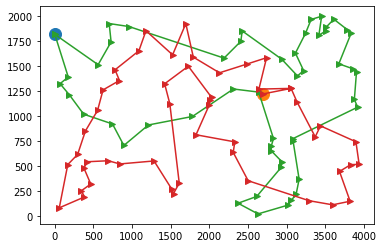

In [23]:
#MAIN - tu poskladac wyzej zaimplementowane funkcje w 8 roznych kombinacji algorytmow i sprawdzic ich czasy i wyplotowac skutecznosci


for dataset_choice in ['kroa', 'krob']:
    if dataset_choice=="kroa":
        dataset=np_kroa
        dist=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dist=copy.deepcopy(distb)
    
    timeTable = []
    cyclesTable = []
    distanceTable = []
    for _ in range(K):
        
        distanceTableBuffer = []
        cyclesTableBuffer = []
        bestDistance = 0
        startTime = time()
        for _ in tqdm(range(N)):

            cycles, bestDistance = greedy_search(dist, dataset, init_random = True, switch="change_edges")
            distanceTableBuffer.append(bestDistance)
            cyclesTableBuffer.append(cycles)
        timeTable.append(time() - startTime)
        distanceTable.append(np.min(distanceTableBuffer))
        cyclesTable.append( cyclesTableBuffer[np.argmin(distanceTableBuffer) ] )
    
    print(f"greedy_search- time_mean:{np.mean(timeTable)},  time_min:{np.min(timeTable)}, time_max:{np.max(timeTable)}, min:{np.min(distanceTable)}, max:{np.max(distanceTable)}, mean:{np.mean(distanceTable)}")


    cycles = cyclesTable[np.argmin(distanceTable)]
    plt.clf()
    plt.plot(dataset[:,0][cycles[0][0]], dataset[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(dataset[:,0][cycles[1][0]], dataset[:,1][cycles[1][0]], "o", markersize=12)                
    plt.plot(dataset[:,0][[*cycles[0],cycles[0][0]]], dataset[:,1][[*cycles[0],cycles[0][0]]], "->")
    plt.plot(dataset[:,0][[*cycles[1],cycles[1][1]]], dataset[:,1][[*cycles[1],cycles[1][1]]], "->")
    plt.show()
    
    plt.savefig(f'greedy_search_best_NN_randomTrue_changeEdges_{dataset_choice}.png')


##  (ILS1) Iterated local search - Iteracyjne przeszukiwanie lokalne z niewielką perturbacją,

In [39]:
# 2nd variable - Find more optimal solution
# switch parameter defines how u find neighbour solutions (is it change_vertices or change_edges func)
def ILS1(dist, np_dots, init_random = True, switch="change_edges", durationSec=10, shakeIt=3):
    #specify cycles initialization.
    if init_random:
        cycles = start_cycle_random()
    else:
        cycles = start_cycle_heuristic()
        
    #print(cycles)
    
    if switch == "change_vertices":
        internal_change = change_vertices
    elif switch == "change_edges":
        internal_change = change_edges
    else:
        print(f"Unknow mode {switch}. Select change_vertices or change_edges")
        return
    
    bestDistance = 0
    bestDistance += calcDistance(cycles[0], dist) 
    bestDistance += calcDistance(cycles[1], dist) 
    #print(f"Initial distance: {bestDistance}")
    
    #plotPartResult(np_dots, cycles)
    
    
    startTime = time()
    while True:
        #-------------calculating possible moves
        possible_moves = []
        
        mesh = np.array(np.meshgrid(cycles[0], cycles[1]))
        combinations = mesh.T.reshape(-1, 2)
        for x in combinations:
            possible_moves.append(["external", x])

        mesh = np.array(np.meshgrid(cycles[0], cycles[0]))
        mesh = np.concatenate((mesh,np.array(np.meshgrid(cycles[1], cycles[1]))),axis=0)
        combinations = mesh.T.reshape(-1, 2)
        for x in combinations:
            possible_moves.append(["internal", x])
        
        possible_moves = np.array(possible_moves)
        i = np.random.choice(range(len(possible_moves)),len(possible_moves),replace=False)
        possible_moves = possible_moves[i]
        
        
        for move, edges in possible_moves:
            bestPossible = True
#             print(move, edges)
            cyclesCopy = copy.deepcopy(cycles)
            edge1 = edges[0]
            edge2 = edges[1]
            
#             print(edge1, edge2)
            if move == "internal":
                cyclesCopy = internal_change(cyclesCopy, edge1, edge2, internally=True)
            else:
                cyclesCopy = change_vertices(cyclesCopy, edge1, edge2, False)
#             plotPartResult(np_dots, cycles)
            currentDistance = 0
            currentDistance += calcDistance(cyclesCopy[0], dist)
            currentDistance += calcDistance(cyclesCopy[1], dist)
            if currentDistance < bestDistance:
                #print(f"New best distance: {currentDistance}, changed {edge1} with {edge2} on {move}")
                cycles = cyclesCopy
                bestDistance = currentDistance
                bestPossible = False
                break
        
        if not bestPossible:
            continue
        plotResult(np_dots, cycles)
        
        if time() - startTime > durationSec:
            break
        
        # Shake it
        
        for _ in range(shakeIt):
            possible_moves = []

            mesh = np.array(np.meshgrid(cycles[0], cycles[1]))
            combinations = mesh.T.reshape(-1, 2)
            for x in combinations:
                possible_moves.append(["external", x])

            mesh = np.array(np.meshgrid(cycles[0], cycles[0]))
            mesh = np.concatenate((mesh,np.array(np.meshgrid(cycles[1], cycles[1]))),axis=0)
            combinations = mesh.T.reshape(-1, 2)
            for x in combinations:
                possible_moves.append(["internal", x])

            possible_moves = np.array(possible_moves)
            i = np.random.choice(range(len(possible_moves)),1,replace=False)
            possible_moves = possible_moves[i]
            
            for move, edges in possible_moves:
                edge1 = edges[0]
                edge2 = edges[1]

                print(edge1, edge2)
                if move == "internal":
                    cycles = internal_change(cycles, edge1, edge2, internally=True)
                else:
                    cycles = change_vertices(cycles, edge1, edge2, False)
    
        plotResult(np_dots, cycles)
            
    
#     plotPartResult(np_dots, cycles)
#     plt.show()
    return cycles, bestDistance






  0%|          | 0/2 [00:00<?, ?it/s]/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


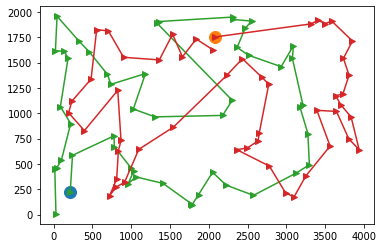

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


44 13
82 19
33 87


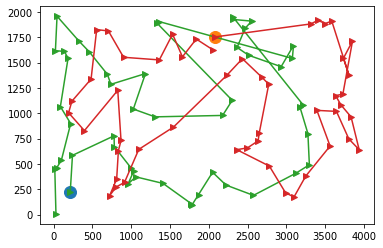

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


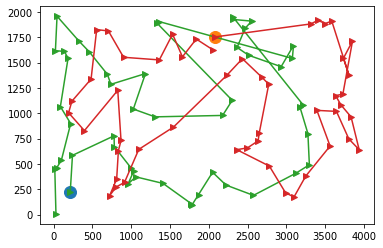

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


83 12
69 1
95 60


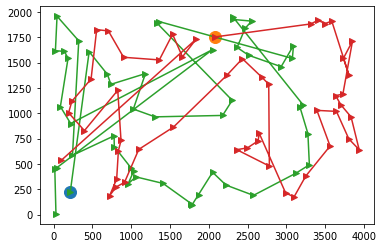

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


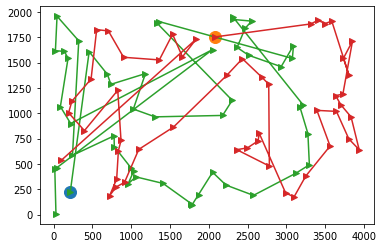

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


26 67
80 62
37 85


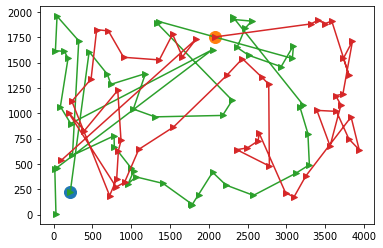

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


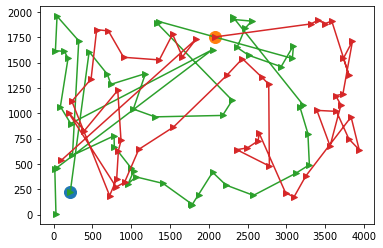

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


99 26
88 19
40 94


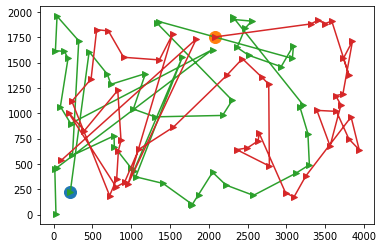

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


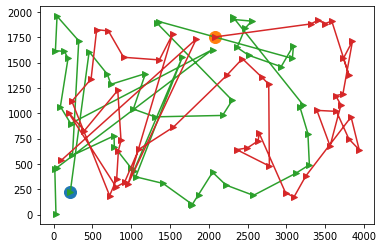

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


27 96
74 57
43 6


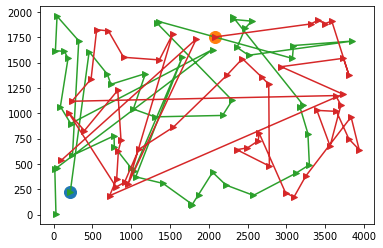

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


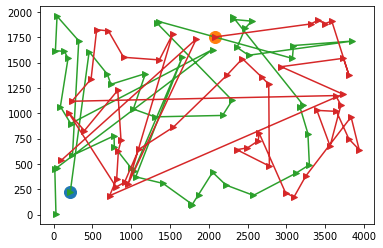

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


79 18
58 62
79 88


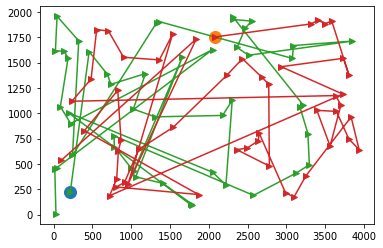

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


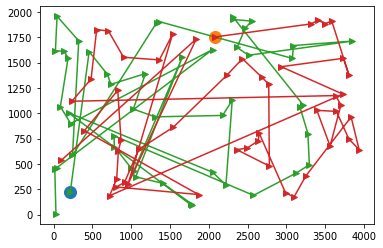

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


30 64
87 32
80 29


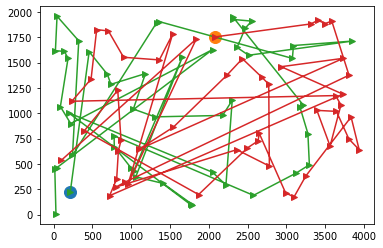

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


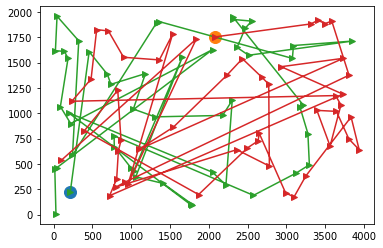

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


64 15
78 96
46 89


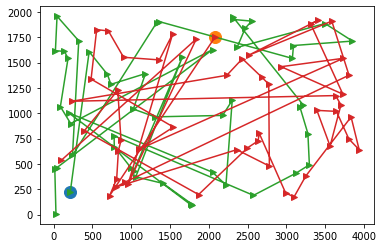

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


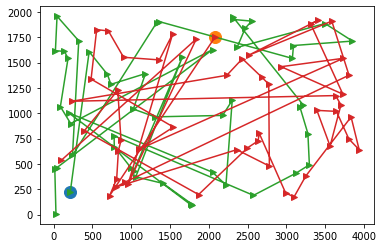

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


44 55
43 22
78 31


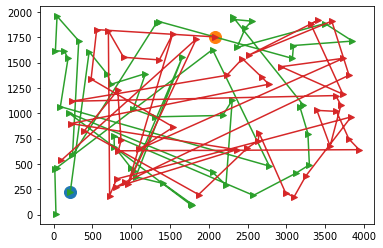

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


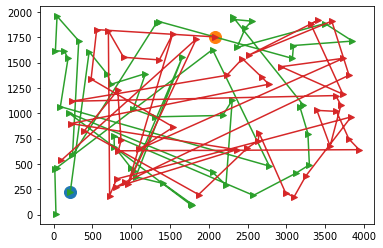

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


54 48
90 65
17 31


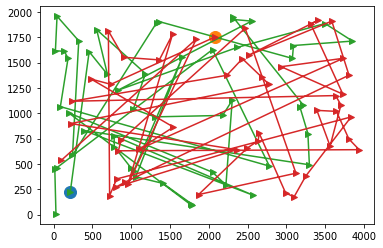

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


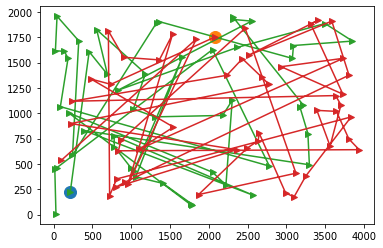

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


49 30
3 96
30 6


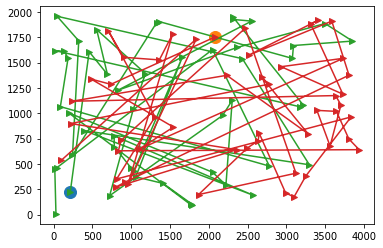

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


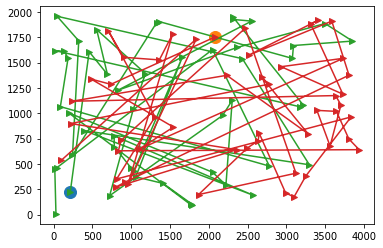

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


51 45
63 54
10 81


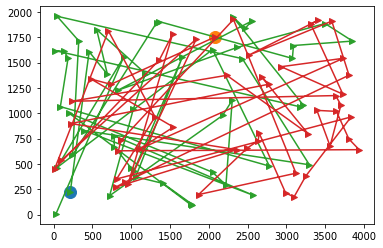

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


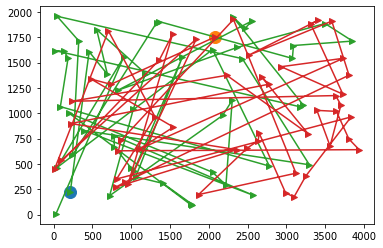

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


96 71
56 38
36 37


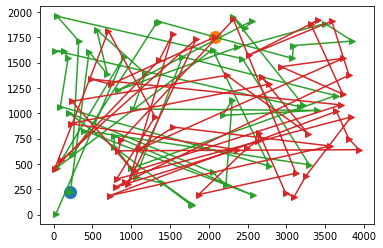

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


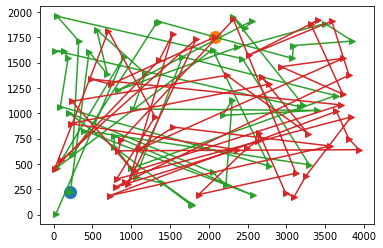






 50%|█████     | 1/2 [00:30<00:30, 30.05s/it]/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


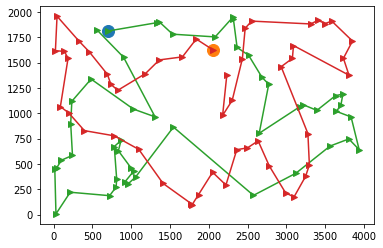

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0 33
93 79
89 93


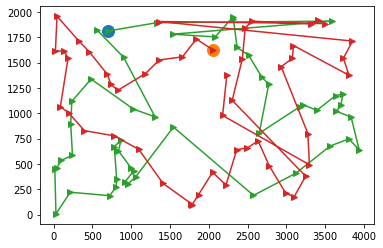

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


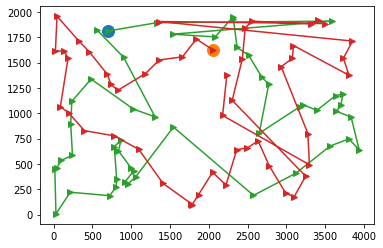

6 14
53 44
40 50


/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


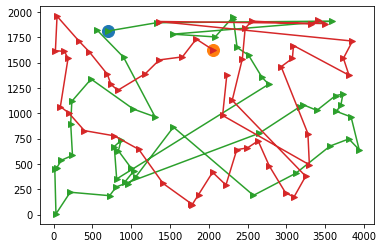

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


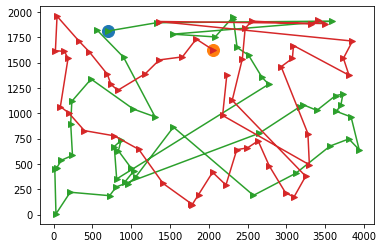

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


51 49
42 87
57 25


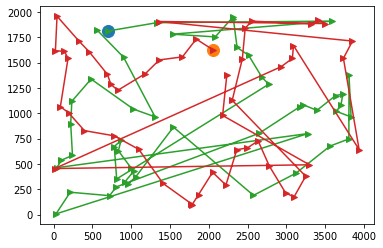

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


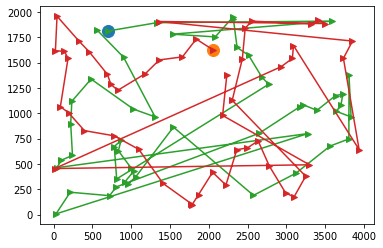

46 73
98 84
98 31


/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


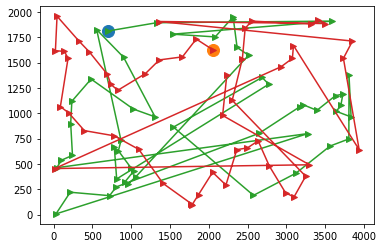

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


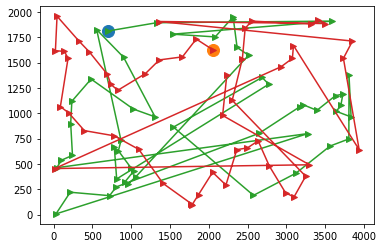

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


56 26
32 8
94 77


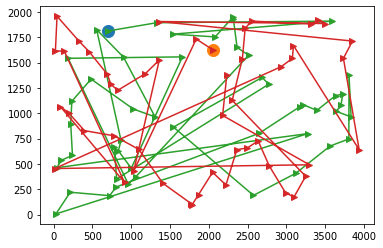

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


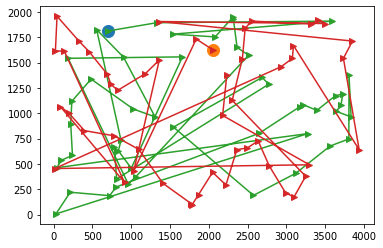

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


65 72
23 31
79 48


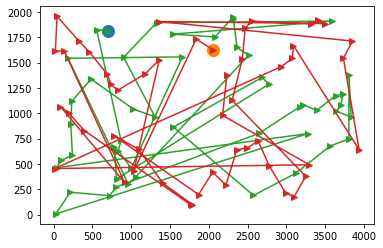

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


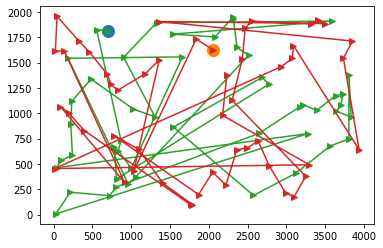

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


44 89
34 41
5 81


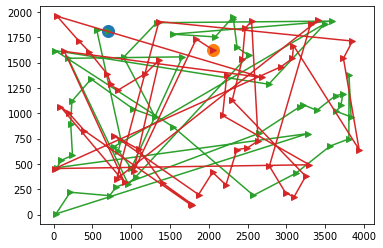

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


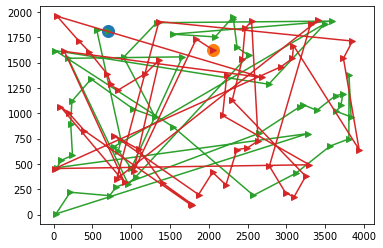

26 15
36 49
81 99


/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


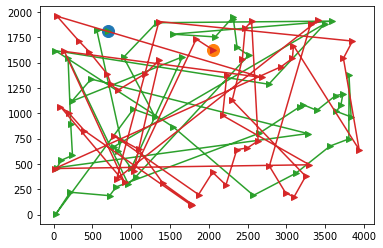

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


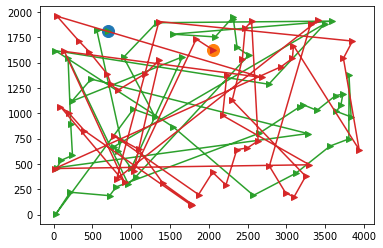

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


73 71
70 41
96 75


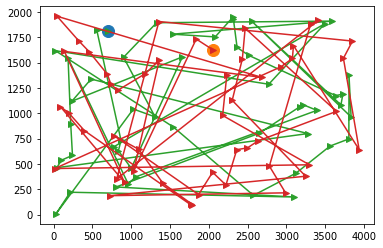

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


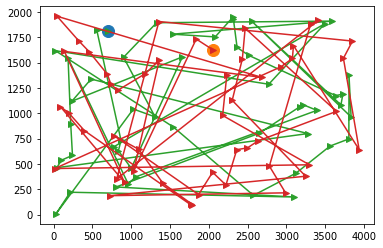

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


9 68
57 64
53 77


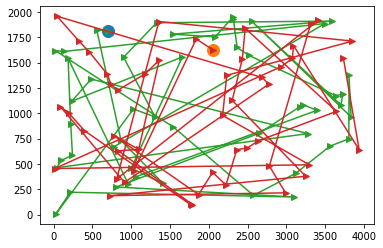

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


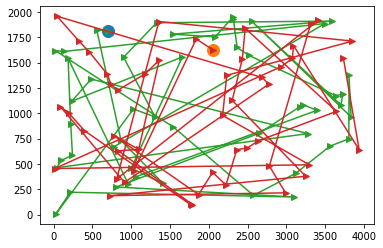

73 24
86 67
3 10


/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


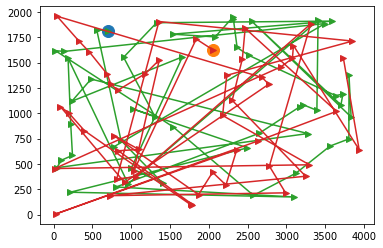

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


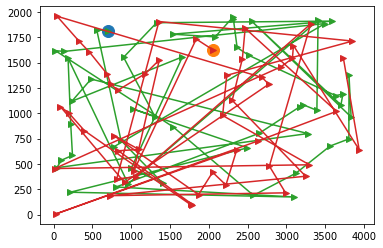

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


81 52
89 38
73 76


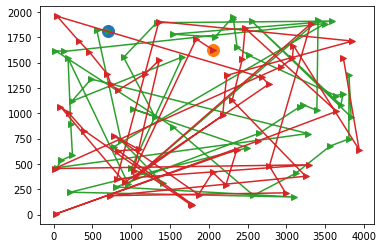

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


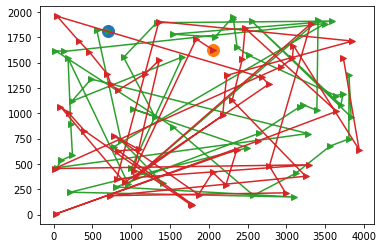

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


78 39
3 20
44 13


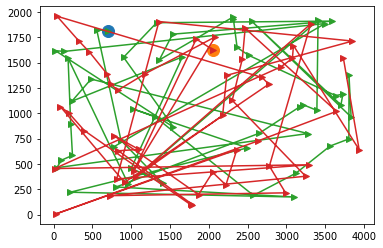

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


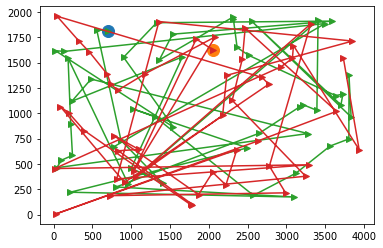

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


71 27
23 37
38 89


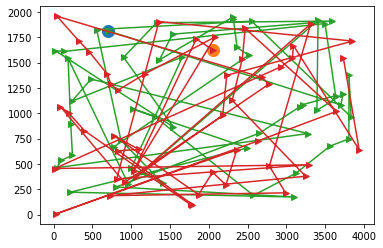

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


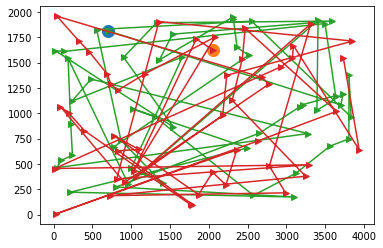

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


80 45
19 9
91 89


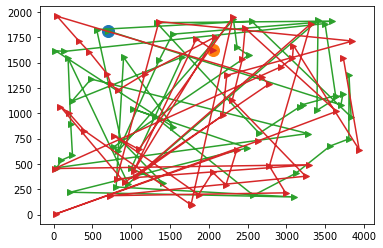

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


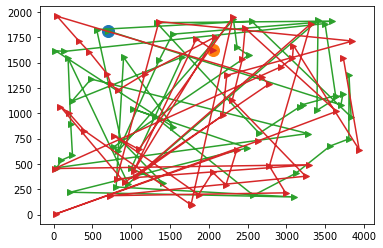






100%|██████████| 2/2 [01:00<00:00, 30.27s/it]

greedy_search- min:27999.898089646907, max:29199.462777814057, mean:28599.680433730482


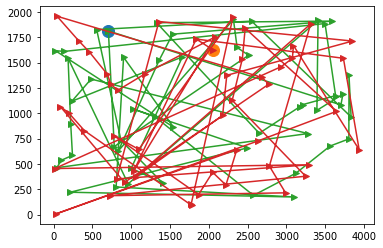






  0%|          | 0/2 [00:00<?, ?it/s]/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


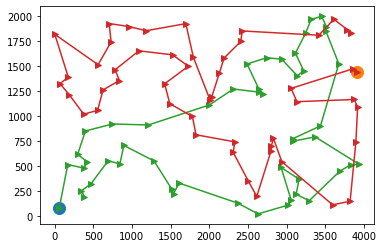

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


95 73
23 49
69 15


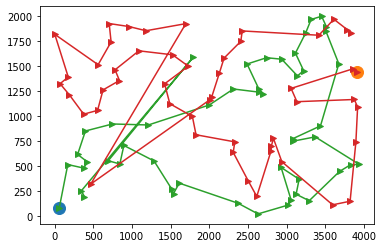

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


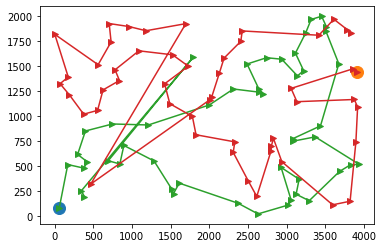

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


30 1
34 52
1 1


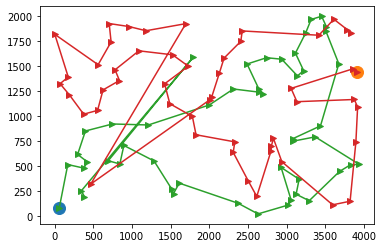

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


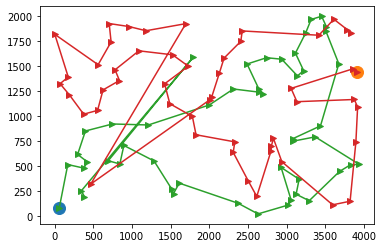

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


17 91
79 81
38 41


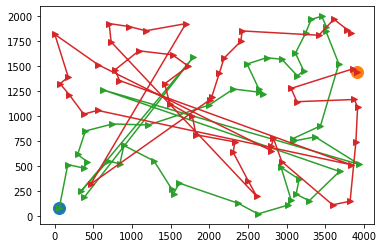

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


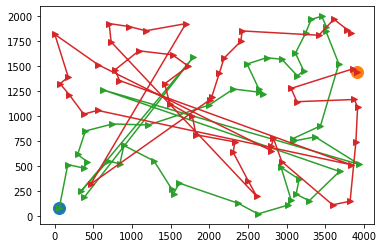

4 1
8 93
85 31


/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


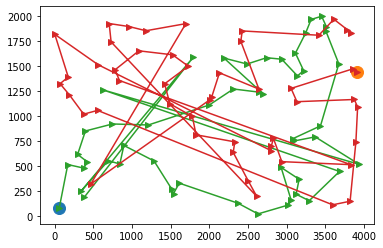

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


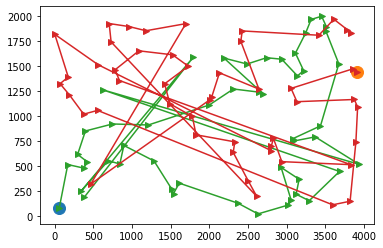

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


16 88
22 70
21 50


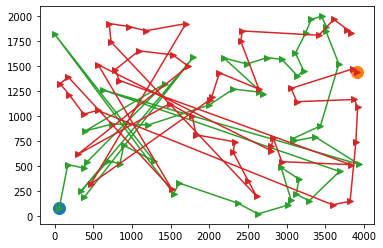

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


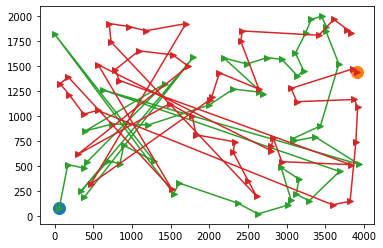

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


16 6
72 1
51 53


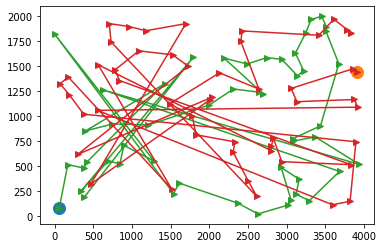

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


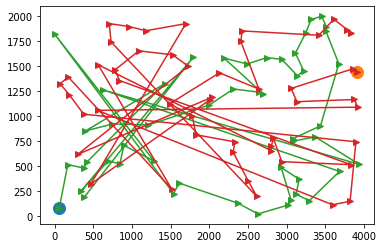

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


43 84
87 79
24 81


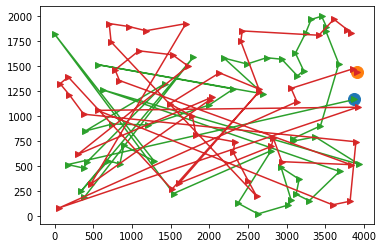

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


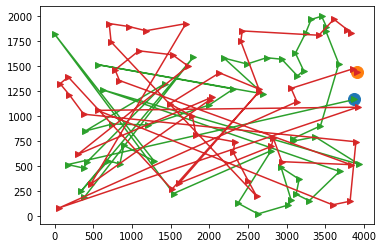

96 8
61 74
66 42


/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


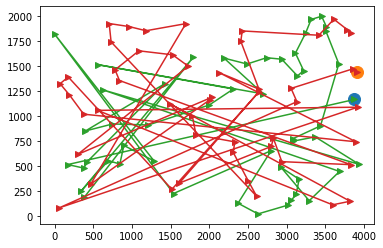

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


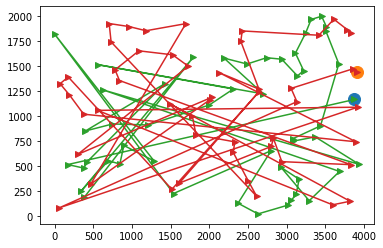

24 60
61 87
91 94


/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


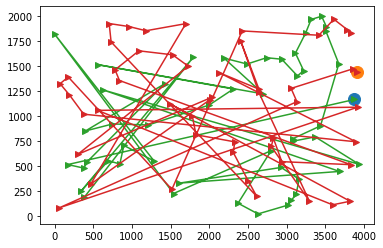

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


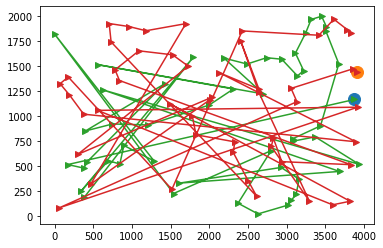

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


41 51
40 12
83 52


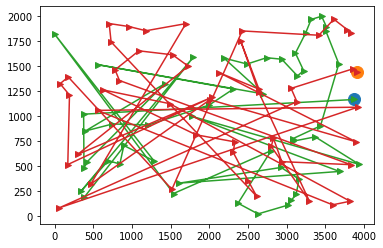

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


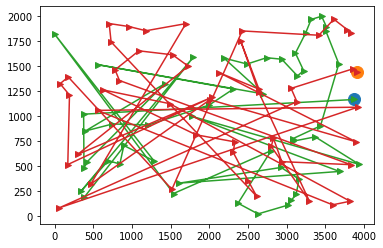

31 54
62 28
70 65


/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


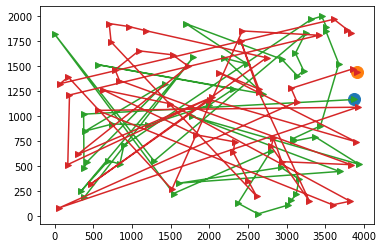

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


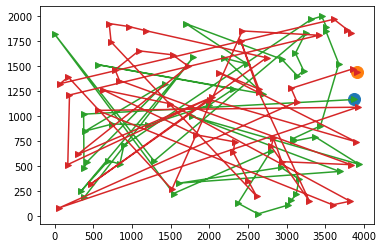

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


97 65
85 8
5 36


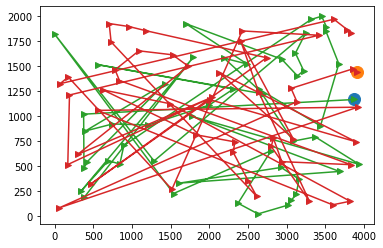

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


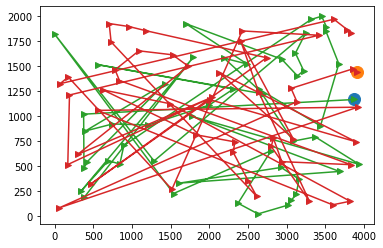

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


30 32
84 81
70 27


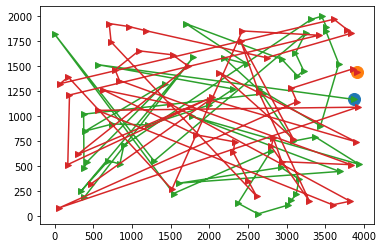

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


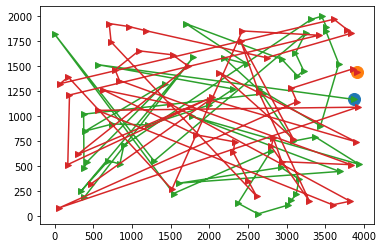

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


84 24
70 53
67 85


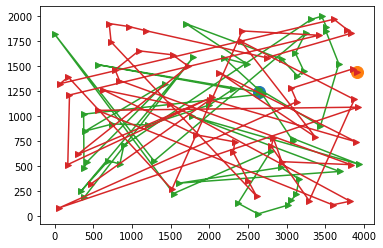

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


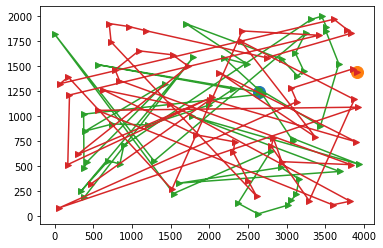

79 5
31 57
46 99


/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


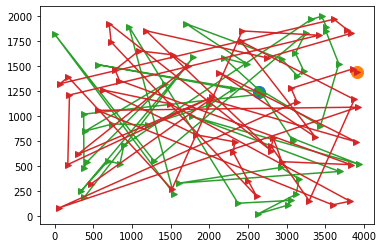

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


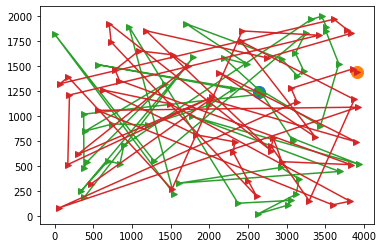

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


22 3
20 66
51 51


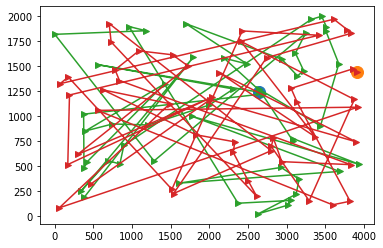

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


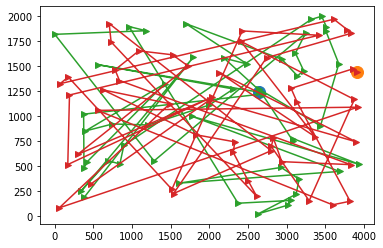






 50%|█████     | 1/2 [00:31<00:31, 31.04s/it]/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


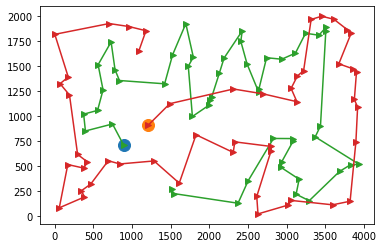

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


70 88
98 36
80 62


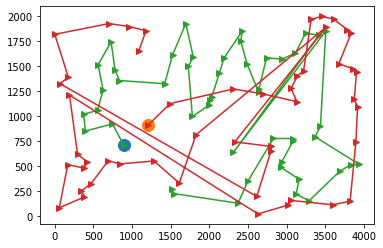

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


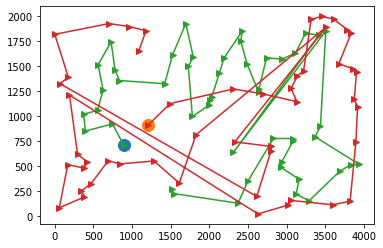

21 29
65 27
41 28


/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


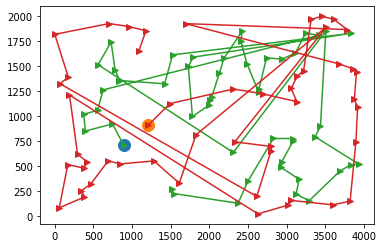

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


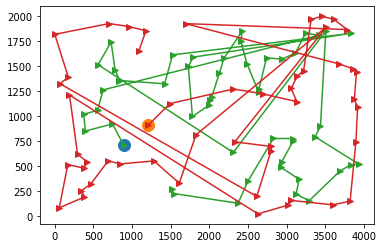

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


33 50
6 96
38 76


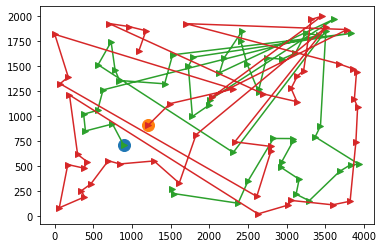

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


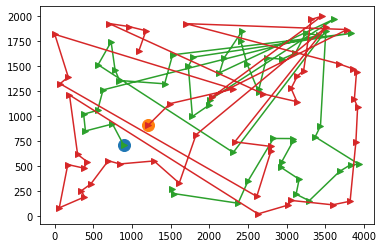

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


81 83
83 39
27 25


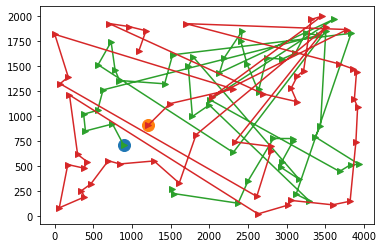

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


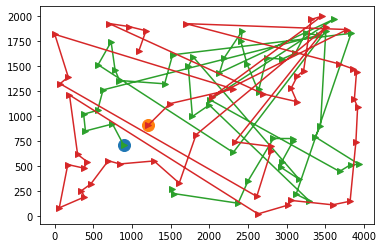

72 20
26 33
69 29


/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


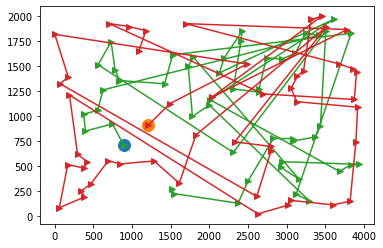

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


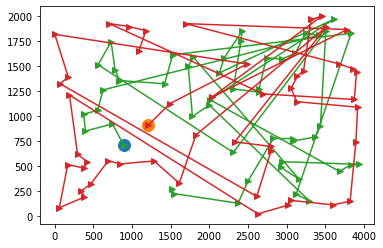

23 18
3 98
59 21


/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


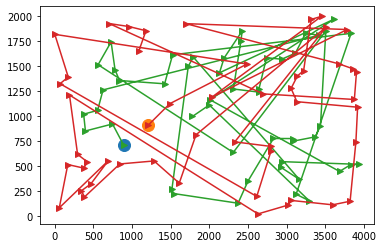

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


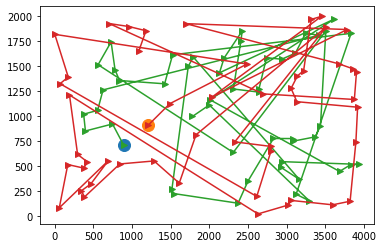

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


85 25
28 58
28 92


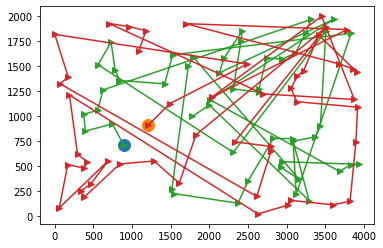

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


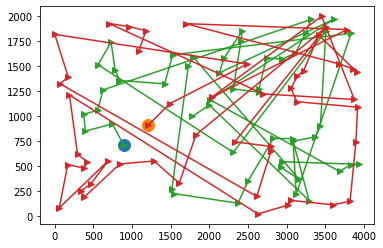

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


93 65
65 92
50 17


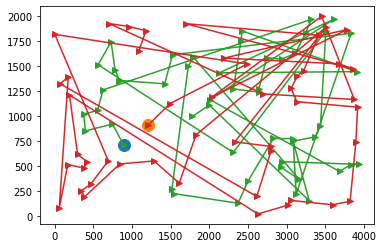

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


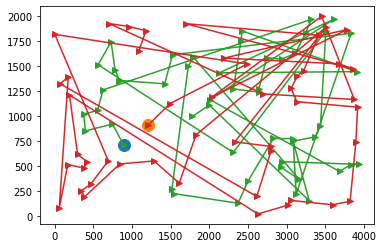

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


82 43
76 36
24 47


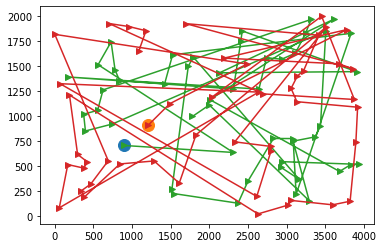

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


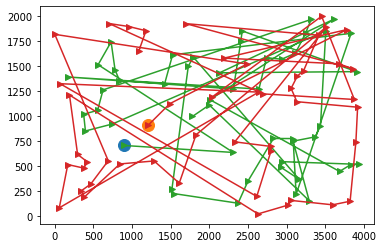

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


56 36
64 91
49 35


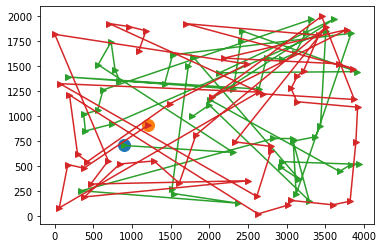

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


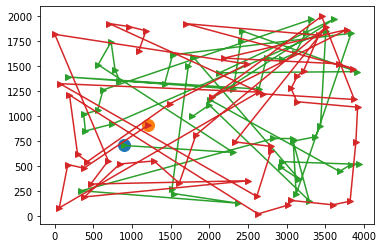

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


1 36
43 90
41 70


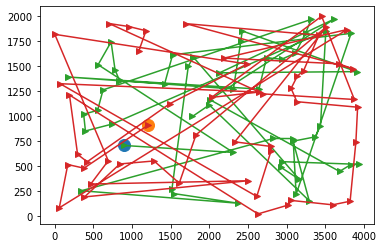

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


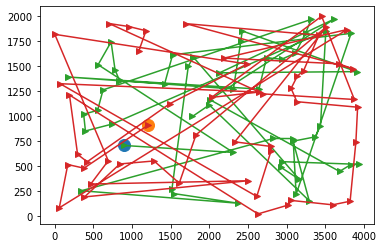

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


8 80
49 16
42 84


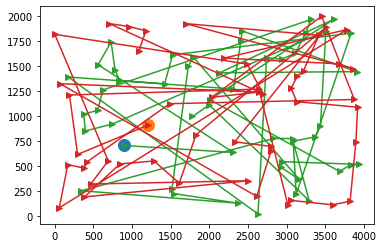

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


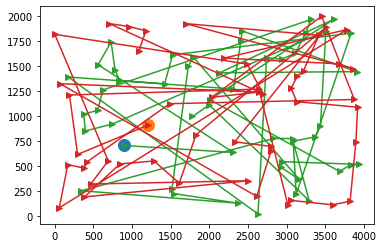






100%|██████████| 2/2 [01:01<00:00, 30.74s/it]

greedy_search- min:28764.693433294044, max:28795.394824492592, mean:28780.044128893318


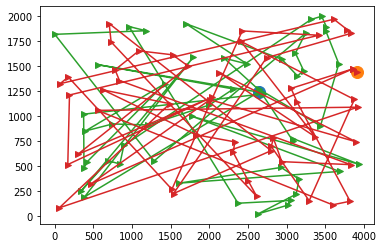

In [40]:
K = 2 # docelowo 10
for dataset_choice in ['kroa', 'krob']:
    if dataset_choice=="kroa":
        dataset=np_kroa
        dist=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dist=copy.deepcopy(distb)
    
    cyclesTable = []
    distanceTable = []
    for _ in tqdm(range(K)):
        cycles, bestDistance = ILS1(dist, dataset, init_random = True, switch="change_edges", durationSec=30, shakeIt=3)
        distanceTable.append(bestDistance)
        cyclesTable.append(cycles )
    
    print(f"greedy_search- min:{np.min(distanceTable)}, max:{np.max(distanceTable)}, mean:{np.mean(distanceTable)}")


    cycles = cyclesTable[np.argmin(distanceTable)]
    plt.clf()
    plt.plot(dataset[:,0][cycles[0][0]], dataset[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(dataset[:,0][cycles[1][0]], dataset[:,1][cycles[1][0]], "o", markersize=12)                
    plt.plot(dataset[:,0][[*cycles[0],cycles[0][0]]], dataset[:,1][[*cycles[0],cycles[0][0]]], "->")
    plt.plot(dataset[:,0][[*cycles[1],cycles[1][1]]], dataset[:,1][[*cycles[1],cycles[1][1]]], "->")
    plt.show()
    
    #plt.savefig(f'greedy_search_best_NN_randomTrue_changeEdges_{dataset_choice}.png')


## (ILS2) Iterated local search - Iteracyjne przeszukiwanie lokalne z Large-scale neighborhood search, tj. większą perturbacją typu Destroy-Repair.

In [51]:
# 1st variable - Start cycle - with nearest neighbour method
def rebuild_cycle_heuristic(cycles,dataset_choice="kroa"):
    results=[]
    min_result=np.inf
    max_result=0
    if dataset_choice=="kroa":
        dataset=np_kroa
        dic=kroa
        dist=copy.deepcopy(dista)
        dist_stable=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dic=krob
        dist=copy.deepcopy(distb)
        dist_stable=copy.deepcopy(distb)


    #zmiana dystansu przekątnej na nieskonczonosc
    np.fill_diagonal(dist, np.inf)

#     cycles={}
#     cycles[0]=[randrange(100)]
#     cycles[1]=[(np.argsort(dist[cycles[0][0]])[-2])]

    for b in range(2):
        for d in range(len(cycles[b])):
            dist[:,int(cycles[b][d])]=np.inf

    chosenCycle=1
    taken=len(cycles[0])+len(cycles[1])
    for i in range(0,100-taken):
        chosenCycle = int((chosenCycle + 1)%2)
        candidates=[]
        for z,index in enumerate(cycles[chosenCycle]):
            candidates.append((np.argmin(dist[index]),np.min(dist[index]),z))
        candidates=np.array(candidates)
        x=np.argmin(candidates[:,1])
        cycles[chosenCycle]=np.insert(cycles[chosenCycle],int(candidates[x,2]),int(candidates[x,0]))
        dist[:,int(candidates[x,0])]=np.inf

#     #SAVING RESULTS 
#     results.append(calcDistance(cycles[0],dist_stable)+calcDistance(cycles[1],dist_stable))
#     if results[-1]>max_result:
#         max_result=results[-1]
#     if results[-1]<min_result:
#         min_result=results[-1]

    return cycles

In [77]:
def ILS2(dist, np_dots, dataset_choice="kroa", init_random = True, switch="change_edges", durationSec=10, shakeIt=20): 
    #shakeIt here defines how many vertices will be freed from each cycle to rebuild it at the end
    #specify cycles initialization.
    if init_random:
        cycles = start_cycle_random()
    else:
        cycles = start_cycle_heuristic()
        
    #print(cycles)
    
    if switch == "change_vertices":
        internal_change = change_vertices
    elif switch == "change_edges":
        internal_change = change_edges
    else:
        print(f"Unknow mode {switch}. Select change_vertices or change_edges")
        return
    
    bestDistance = 0
    bestDistance += calcDistance(cycles[0], dist) 
    bestDistance += calcDistance(cycles[1], dist) 
    #print(f"Initial distance: {bestDistance}")
    
    #plotPartResult(np_dots, cycles)
    
    
    startTime = time()
    while True:
        #-------------calculating possible moves
        possible_moves = []
        
        mesh = np.array(np.meshgrid(cycles[0], cycles[1]))
        combinations = mesh.T.reshape(-1, 2)
        for x in combinations:
            possible_moves.append(["external", x])

        mesh = np.array(np.meshgrid(cycles[0], cycles[0]))
        mesh = np.concatenate((mesh,np.array(np.meshgrid(cycles[1], cycles[1]))),axis=0)
        combinations = mesh.T.reshape(-1, 2)
        for x in combinations:
            possible_moves.append(["internal", x])
        
        possible_moves = np.array(possible_moves)
        i = np.random.choice(range(len(possible_moves)),len(possible_moves),replace=False)
        possible_moves = possible_moves[i]
        
        
        for move, edges in possible_moves:
            bestPossible = True
#             print(move, edges)
            cyclesCopy = copy.deepcopy(cycles)
            edge1 = edges[0]
            edge2 = edges[1]
            
#             print(edge1, edge2)
            if move == "internal":
                cyclesCopy = internal_change(cyclesCopy, edge1, edge2, internally=True)
            else:
                cyclesCopy = change_vertices(cyclesCopy, edge1, edge2, False)
#             plotPartResult(np_dots, cycles)
            currentDistance = 0
            currentDistance += calcDistance(cyclesCopy[0], dist)
            currentDistance += calcDistance(cyclesCopy[1], dist)
            if currentDistance < bestDistance:
                #print(f"New best distance: {currentDistance}, changed {edge1} with {edge2} on {move}")
                cycles = cyclesCopy
                bestDistance = currentDistance
                bestPossible = False
                break
        
        
        #plotResult(np_dots, cycles)
        
        
        # Shake it
        print(cycles,len(cycles[0]))
        cyclesDestroyed=dict()
        cyclesIndexes=dict()
        cyclesDestroyed[0]=cycles[0][np.sort(np.random.choice(len(cycles[0]), size=len(cycles[0])-shakeIt, replace=False))]
        cyclesDestroyed[1]=cycles[1][np.sort(np.random.choice(len(cycles[1]), size=len(cycles[1])-shakeIt, replace=False))]
        cyclesRebuilt=rebuild_cycle_heuristic(cyclesDestroyed,dataset_choice)

        
        #PORÓWNAJ CZASOWO
        
        
        if time() - startTime > durationSec:
                break

    return cycles, bestDistance

In [78]:
K = 1 # docelowo 10
for dataset_choice in ['kroa']:#, 'krob']:
    if dataset_choice=="kroa":
        dataset=np_kroa
        dist=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dist=copy.deepcopy(distb)
    
    cyclesTable = []
    distanceTable = []
    for _ in tqdm(range(K)):
        cycles, bestDistance = ILS2(dist, dataset, dataset_choice="kroa", init_random = True, switch="change_edges", durationSec=10, shakeIt=10)
        distanceTable.append(bestDistance)
        cyclesTable.append(cycles )
    
    print(f"greedy_search- min:{np.min(distanceTable)}, max:{np.max(distanceTable)}, mean:{np.mean(distanceTable)}")


    cycles = cyclesTable[np.argmin(distanceTable)]
#     plt.clf()
#     plt.plot(dataset[:,0][cycles[0][0]], dataset[:,1][cycles[0][0]], "o", markersize=12)
#     plt.plot(dataset[:,0][cycles[1][0]], dataset[:,1][cycles[1][0]], "o", markersize=12)                
#     plt.plot(dataset[:,0][[*cycles[0],cycles[0][0]]], dataset[:,1][[*cycles[0],cycles[0][0]]], "->")
#     plt.plot(dataset[:,0][[*cycles[1],cycles[1][1]]], dataset[:,1][[*cycles[1],cycles[1][1]]], "->")
#     plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]/usr/lib/python3/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


{0: array([64, 18, 52, 87, 15, 69, 21, 93, 78, 17, 83,  9, 89, 48,  5, 62, 46,
       90, 97, 76, 50, 86,  6, 54, 82, 33, 45, 42,  2, 13, 70, 40, 99, 47,
       28, 29, 84, 67, 49, 43, 72, 80, 24, 66,  0, 91,  7, 74, 96,  3]), 1: array([31, 44, 22, 59, 61, 34, 85, 26, 11, 19, 56,  8, 38, 95, 77, 51,  4,
       36, 32, 75, 12, 94, 81,  1, 53, 39, 63, 68, 60, 57, 92, 27, 41, 88,
       30, 79, 55, 25, 65, 23, 37, 98, 35, 71, 20, 73, 58, 16, 14, 10])} 50
{0: array([64, 18, 52, 87, 15, 69, 21, 93, 78, 17, 83,  9, 89, 48,  5, 62, 46,
       90, 97, 76, 50, 86,  6, 54, 82, 33, 45, 42,  2, 13, 70, 40, 99, 47,
       28, 29, 84, 67, 49, 43, 72, 80, 24, 66,  0, 91,  7, 74, 96,  3]), 1: array([31, 44, 22, 59, 61, 34, 85, 26, 11, 19, 56,  8, 38, 95, 77, 51,  4,
       36, 32, 75, 12, 94, 81,  1, 53, 39, 63, 68, 60, 57, 92, 27, 41, 88,
       30, 79, 55, 25, 65, 23, 37, 98, 35, 71, 20, 73, 58, 16, 14, 10])} 50
{0: array([64, 18, 52, 87, 15, 69, 21, 93, 78, 17, 83,  9, 89, 48,  5, 62, 46,
       90

100%|██████████| 1/1 [00:10<00:00, 10.35s/it]

greedy_search- min:26796.69348926642, max:26796.69348926642, mean:26796.69348926642
